In [33]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from attention.img_proc.img_process import *
from attention.img_proc.img_split import *
from attention.models.face_models import *
from attention.utils.img_plot import *
from attention.utils.utilities import *
from attention.params import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Get attention_data directory
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, os.pardir, "attention_data")

In [35]:
# Converting video to frames:
video_folder_path = os.path.join(data_directory, "video")
video_name = "Midbatch.MOV"
video_path = os.path.join(video_folder_path, video_name)
frames = extract_video_frames(video_path, 
                              period_sec=1,
                              start_sec=30, end_sec=330)

# Saving the frames
image_folder_path = os.path.join(data_directory, "frames")
for timestamp, frame in frames.items():
    frame_name = video_name.split('.')[0] + f'_ds{int(timestamp * 10)}'
    save_image(frame, frame_name + '.png', image_folder_path)

In [36]:
# Training the face recognition model
known_folder_path = os.path.join(data_directory, "known_faces")
known_paths = load_image_paths(known_folder_path)
known_names = list(known_paths.keys())
known_faces = [read_image(image_path) for image_path in known_paths.values()]
known_encodings = train_faces(known_faces, known_names)

In [37]:
# PARAMS:
n_split_w = 6
n_split_h = 6
landmark_idx = LEFT_EYE_EDGES  + LEFT_IRIS_CENTER + RIGHT_EYE_EDGES + RIGHT_IRIS_CENTER

# Dataframe columns
df_columns =  ['frame',
'timestamp',
'face_idx',
'recognition_prediction',
'recognition_distance',
'attentive',
'left_prediction',
'left_score',
'right_prediction',
'right_score',
'head_direction_prediction',
'head_direction_score',
'head_inclination_prediction',
'head_inclination_score']

In [53]:
image_folder_path = os.path.join(data_directory, "frames")
image_paths = load_image_paths(image_folder_path)

attention_df = pd.DataFrame(columns=df_columns)         

for image_name, image_path in image_paths.items():
    # Loading image
    image = read_image(image_path)
    timestamp = int(image_name.split('_ds')[1]) if '_ds' in image_name else np.nan
    # Splitting image
    crops = split_image(image, n_split_w, n_split_h, 0.05, 0.05)
    # Generating bboxes for each crop
    bbox_crop_list = []
    bbox_crop_list_absolute = []
    for crop in crops:
        coord_set = detect_face(crop.image)
        bbox_crop_list.append(coord_set)
        coord_set_absolute = reconstruct_coord(crop, coord_set)
        bbox_crop_list_absolute.append(coord_set_absolute)
    bbox_crop_list_absolute
    # Eliminating duplicates bboxes
    bbox_list = bbox_merge(bbox_crop_list_absolute, intersect_threshold=0.6)
    # Drawing the unique bboxes on the original image
    image_output = annotate_bboxes(image, bbox_list)
    # Saving the image with its bboxes
    bbox_path = os.path.join(data_directory, "output_bbox")
    save_image(image_output, image_name + '.png', bbox_path)
    
    # Generating face crops
    faces = crop_faces(image, bbox_list)
    # Saving face crops
    face_path = os.path.join(data_directory, "face_crops")
    for face_idx, face in enumerate(faces):
        face_name = image_name + f'_{face_idx}'
        save_image(face, face_name + '.png', face_path)
    
    # Generating eye and iris landmarks
    for face_idx, face in enumerate(faces):
        face_name = image_name + f'_{face_idx}'
        mp_landmarks = find_landmarks(face)
        if mp_landmarks:                # Only run attention/ recognition if it detects a face
            # Converting the Mediapipe landmark to a standard system of coordinates
            landmark_list = convert_landmarks(face, mp_landmarks)
            # Drawing the face mesh on the face
            face_mesh = annotate_mesh(face, mp_landmarks)
            # Saving face with complete mesh
            mesh_path = os.path.join(data_directory, "output_mesh")
            save_image(face_mesh, face_name + '.png', mesh_path)
            
            # Detecting eye direction and attention
            face_name = image_name + f'_{face_idx}'
            eye_directions = detect_eye_directions(landmark_list, threshold = 0.63)
            head_direction = detect_head_direction(landmark_list, left_threshold = 0.35, right_threshold = 1)
            head_inclination = detect_head_inclination(landmark_list, down_threshold = 1.73, up_threshold = 0.8)
            attention = is_attentive(eye_directions, head_direction, head_inclination)
            # Drawing iris landmarks + annotating attention results on original image
            prediction_left, score_left = eye_directions['left']
            prediction_right, score_right = eye_directions['right']
            prediction_head_direction, score_head_direction = head_direction
            prediction_head_inclination, score_head_inclination = head_inclination
            prediction_attention = 'attentive' if attention else 'inattentive'
            face_attention = annotate_attention(face, landmark_list, 
                                                    prediction_left, score_left, 
                                                    prediction_right, score_right,
                                                    prediction_head_direction, score_head_direction,
                                                    prediction_head_inclination, score_head_inclination,
                                                    prediction_attention)
            
            
            # Saving attention image output
            attention_path = os.path.join(data_directory, "output_attention")
            save_image(face_attention, face_name + '.png', attention_path)
        
            # Recognizing a face
            face_name = image_name + f'_{face_idx}'
            face_prediction = recognize_face(face, known_encodings)
            #Annotating name and distance on the face image
            prediction_recognition, distance_recognition = face_prediction
            face_recognition = annotate_recognition(face, prediction_recognition, distance_recognition)
            # Saving recognition image output
            recognition_path = os.path.join(data_directory, "output_recognition")
            save_image(face_recognition, face_name + '.png', recognition_path)
            
            # Saving data in the dataframe
            attention_df.loc[len(attention_df)] = [image_name,
                                                    timestamp,
                                                    face_idx,
                                                    prediction_recognition,
                                                    distance_recognition,
                                                    attention,
                                                    prediction_left,
                                                    score_left,
                                                    prediction_right,
                                                    score_right,
                                                    prediction_head_direction,
                                                    score_head_direction,
                                                    prediction_head_inclination,
                                                    score_head_inclination]
    

In [111]:
attention_df.to_csv(os.path.join(data_directory,'attention_output.csv'), index=False)

<Axes: xlabel='timestamp'>

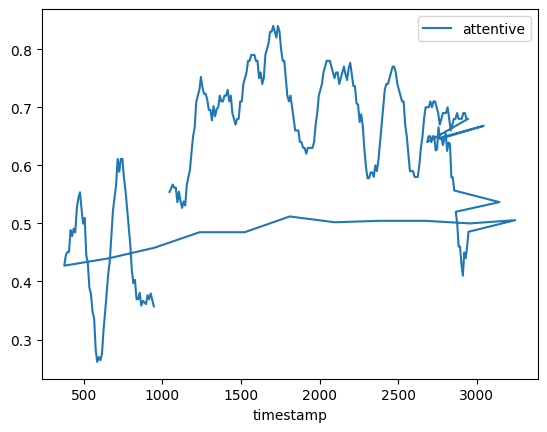

In [88]:
attention = attention_df.groupby('timestamp')[['attentive']].mean()
attention_mov = attention.reset_index().sort_values(by = 'timestamp').rolling(window=10).mean()
# attention_mov = attention.rolling(window=10).mean()
attention_mov.plot(x='timestamp', y='attentive')

In [57]:
attention_df.groupby('timestamp')[['face_idx']].count().mean()

face_idx    9.443333
dtype: float64

In [58]:
attention_df['recognition_prediction'].value_counts(normalize=True,dropna=False).round(2)

NaN         0.22
Noah        0.10
Agos        0.10
Julie       0.10
Isa         0.09
Emi         0.09
Gonzalo     0.08
Sara        0.07
Lancelot    0.07
Juliette    0.07
Leo         0.00
Emilia      0.00
Amine       0.00
Name: recognition_prediction, dtype: float64